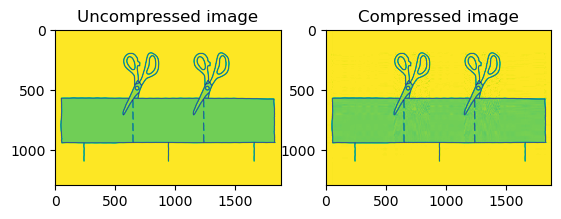

original image size: 2436480, compressed image size: 158850, factor 15.338 saving


In [1]:
import numpy as np
import matplotlib.pyplot as plt

img_path = "./simulation_thumbnail.png"
img = plt.imread(img_path)

# only look at one color channel for demonstration purposes
img = img[:, :, 0]

# Perform SVD
U, Lambda, Vd = np.linalg.svd(img)

# Keep only the 50 largest singular values and vectors
chi = 50
U_compressed = U[:, :chi]
Lambda_compressed = Lambda[:chi]
Vd_compressed = Vd[:chi]

# Reconstruct the compressed image
compressed_img = U_compressed @ np.diag(Lambda_compressed) @ Vd_compressed

fig, axs = plt.subplots(ncols=2)
ax = axs[0]
ax.imshow(img, vmin=0, vmax=1)
ax.set_title("Uncompressed image")

ax = axs[1]
ax.imshow(compressed_img, vmin=0, vmax=1)
ax.set_title("Compressed image")

plt.show()

size_original = np.prod(img.shape)
size_compressed = np.prod(U_compressed.shape) + np.prod(Lambda_compressed.shape) + np.prod(Vd_compressed.shape)

print(f"original image size: {size_original}, compressed image size: {size_compressed}, factor {size_original/size_compressed:.3f} saving")

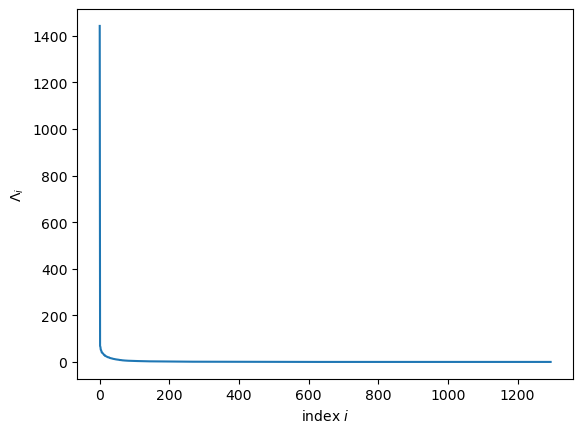

In [2]:
_, Lambda, _ = np.linalg.svd(img) # recompute the full spectrum
plt.plot(Lambda)
plt.xlabel("index $i$")
plt.ylabel("$\\Lambda_i$")
plt.show()

In [3]:
n = 3 # three sites = three legs
psi = np.random.rand(2**3)
psi = psi / np.linalg.norm(psi)  # random, normalized state vector
psi = np.reshape(psi, (2, 2, 2)) # rewrite psi as rank-n tensor

In [4]:
# reshape vector to matrix
psi = np.reshape(psi, (2, 2**(n-1)))
# SVD to split off first site
U, Lambda, Vd = np.linalg.svd(psi, full_matrices=False)

In [5]:
Us = []
U = np.reshape(U, (1, 2, 2)) # mu1, s2, mu2
Us.append(U)

In [6]:
psi_remainder = np.diag(Lambda) @ Vd                 # mu1 (s2 s3)
psi_remainder = np.reshape(psi_remainder, (2*2, 2))  # (mu1 s2), s3
U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

U = np.reshape(U, (2, 2, 2)) # mu1, s2, mu2
Us.append(U)

U.shape, Lambda.shape, Vd.shape

((2, 2, 2), (2,), (2, 2))

In [7]:
psi_remainder = np.diag(Lambda) @ Vd                 # mu1 (s2 s3)
psi_remainder = np.reshape(psi_remainder, (2*2, 1))  # (mu1 s2), s3
U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

U = np.reshape(U, (2, 2, 1)) # mu1, s2, mu2
Us.append(U)

U.shape, Lambda.shape, Vd.shape

((2, 2, 1), (1,), (1, 1))

In [8]:
print(f"Shapes of Us: {[_.shape for _ in Us]}")

psi_reconstruct = Us[0]

for i in range(1, len(Us)):
    # contract the rightmost with the left most index
    psi_reconstruct = np.tensordot(psi_reconstruct, Us[i], axes=1)

print(f"Shape of reconstructed psi: {psi_reconstruct.shape}")
# remove dummy dimensions
psi_reconstruct = np.reshape(psi_reconstruct, (2, 2, 2))
# original shape of original psi
psi = np.reshape(psi, (2, 2, 2))

np.allclose(psi, psi_reconstruct)

Shapes of Us: [(1, 2, 2), (2, 2, 2), (2, 2, 1)]
Shape of reconstructed psi: (1, 2, 2, 2, 1)


True

In [9]:
def split(M, bond_dim):
    """Split a matrix M via SVD and keep only the ``bond_dim`` largest entries."""
    U, S, Vd = np.linalg.svd(M, full_matrices=False)
    bonds = len(S)
    Vd = Vd.reshape(bonds, 2, -1)
    U = U.reshape((-1, 2, bonds))

    # keep only chi bonds
    chi = np.min([bonds, bond_dim])
    U, S, Vd = U[:, :, :chi], S[:chi], Vd[:chi]
    return U, S, Vd

def dense_to_mps(psi, bond_dim):
    """Turn a state vector ``psi`` into an MPS with bond dimension ``bond_dim``."""
    Ms = []
    Ss = []

    psi = np.reshape(psi, (2, -1))   # split psi[2, 2, 2, 2..] = psi[2, (2x2x2...)]
    U, S, Vd = split(psi, bond_dim)  # psi[2, (2x2x..)] = U[2, mu] S[mu] Vd[mu, (2x2x2x..)]

    Ms.append(U)
    Ss.append(S)
    bondL = Vd.shape[0]
    psi = np.tensordot(np.diag(S), Vd, 1)

    for _ in range(n-2):
        psi = np.reshape(psi, (2*bondL, -1)) # reshape psi[2 * bondL, (2x2x2...)]
        U, S, Vd = split(psi, bond_dim) # psi[2, (2x2x..)] = U[2, mu] S[mu] Vd[mu, (2x2x2x..)]
        Ms.append(U)
        Ss.append(S)

        psi = np.tensordot(np.diag(S), Vd, 1)
        bondL = Vd.shape[0]

    # dummy step on last site
    psi = np.reshape(psi, (-1, 1))
    U, _, _ = np.linalg.svd(psi, full_matrices=False)

    U = np.reshape(U, (-1, 2, 1))
    Ms.append(U)

    return Ms, Ss

In [10]:
n = 12
bond_dim = 10000

psi = np.random.rand(*[2]*n)
psi = psi/np.linalg.norm(psi)
Ms, Ss = dense_to_mps(psi, bond_dim)

[M.shape for M in Ms]

[(1, 2, 2),
 (2, 2, 4),
 (4, 2, 8),
 (8, 2, 16),
 (16, 2, 32),
 (32, 2, 64),
 (64, 2, 32),
 (32, 2, 16),
 (16, 2, 8),
 (8, 2, 4),
 (4, 2, 2),
 (2, 2, 1)]

In [11]:
Ms, Ss = dense_to_mps(psi, 5)

[M.shape for M in Ms]

[(1, 2, 2),
 (2, 2, 4),
 (4, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 5),
 (5, 2, 4),
 (4, 2, 2),
 (2, 2, 1)]

In [12]:
for i in range(len(Ms)):
    id_ = np.tensordot(Ms[i].conj(), Ms[i], axes=([0, 1], [0, 1]))
    is_id = np.allclose(id_, np.eye(len(id_)))
    print(f"U[{i}] is left-orthonormal: {is_id}")

U[0] is left-orthonormal: True
U[1] is left-orthonormal: True
U[2] is left-orthonormal: True
U[3] is left-orthonormal: True
U[4] is left-orthonormal: True
U[5] is left-orthonormal: True
U[6] is left-orthonormal: True
U[7] is left-orthonormal: True
U[8] is left-orthonormal: True
U[9] is left-orthonormal: True
U[10] is left-orthonormal: True
U[11] is left-orthonormal: True


In [13]:
import pennylane as qml

[dataset] = qml.data.load("qchem", molname="H6", bondlength=0.92, basis="STO-3G")

H = dataset.hamiltonian # molecular Hamiltonian in qubit basis
n_wires = len(H.wires)  # number of qubits

def circuit():
    qml.BasisState(dataset.hf_state, wires=H.wires) # Hartree–Fock initial state
    for op in dataset.vqe_gates:                    # Applying all pre-optimized VQE gates
        qml.apply(op)
    return qml.expval(H)                            # expectation value of molecular Hamiltonian

# set up device with hyper-parameters and kwargs
mps = qml.device("default.tensor", wires=n_wires, method="mps", max_bond_dim=30, contract="auto-mps")

# Create the QNode to execute the circuit on the device, and call it (w/o arguments)
res = qml.QNode(circuit, mps)()

# Compare MPS simulation result with pre-optimized state-vector result
res, dataset.vqe_energy

/opt/anaconda3/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:75: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality hyper-optimization.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


(array(-3.14322664), -3.2448988810510873)

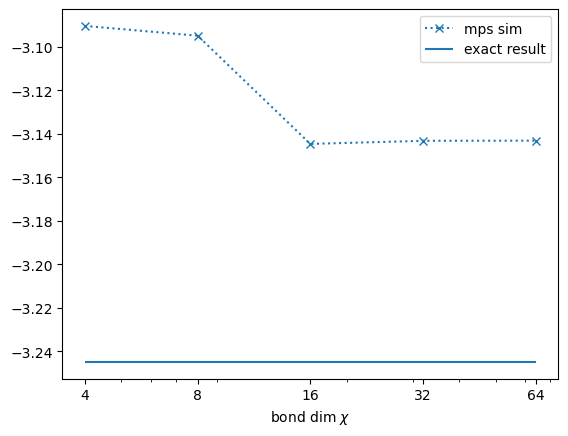

In [14]:
bond_dims = 2**np.arange(2, (n_wires//2)+1) # maximum required bond dimension is 2**(n_wires//2) = 64
ress = []

for bond_dim in bond_dims:
    mps = qml.device("default.tensor", wires=n_wires, method="mps", max_bond_dim=bond_dim, contract="auto-mps")
    res = qml.QNode(circuit, mps)()
    ress.append(res)


plt.plot(bond_dims, ress, "x:", label="mps sim")
plt.hlines(dataset.vqe_energy, bond_dims[0], bond_dims[-1], label="exact result")
plt.xscale("log")
plt.xlabel("bond dim $\\chi$")
plt.xticks(bond_dims, bond_dims)
plt.legend()
plt.show()